In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('./src')
from geometry import *
from tubes import closed_geometry
from solver import stokes2d
import cProfile
import pstats

In [2]:
p1 = np.array([-10,-1])
curve1 = line

p2 = np.array([-1,-1])
curve2 = line

p3 = np.array([-1,-10])
curve3 = cap

p4 = np.array([1,-10])
curve4 = line

p5 = np.array([1,-1])
curve5 = line

p6 = np.array([10,-1])
curve6 = cap

p7 = np.array([10,1])
curve7 = line

p8 = np.array([1,1])
curve8 = line

p9 = np.array([1,10])
curve9 = cap

p10 = np.array([-1,10])
curve10 = line

p11 = np.array([-1,1])
curve11 = line

p12 = np.array([-10,1])
curve12 = cap

In [3]:
pts = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12]
curves = [curve1, curve2, curve3, curve4, curve5, curve6, curve7, curve8, curve9, curve10, curve11, curve12]

In [4]:
cross = closed_geometry(pts,curves,corner_size=0.2)

In [5]:
cross.build_geometry(1e-1)

# solvers, pressure drops, velocity field

In [6]:
inflow = cross.caps[0]
outflows = cross.caps[1:]
flows = [(inflow,outflow) for outflow in outflows]

In [7]:
def get_boundary_velocity_conditions(flow):
    velocity = []
    for i,c in enumerate(cross.curves):
        if i == flow[0]:
            velocity.append(c.get_velocity(flux=1))
        elif i == flow[1]:
            velocity.append(c.get_velocity(flux=-1))
        else:
            velocity.append(c.get_velocity(flux=0))
    return np.concatenate(velocity)

flows_boundary_conditions = [get_boundary_velocity_conditions(flow) for flow in flows]

heuristic, curvature, expansion, 

- see if legendre coefficients decayed. dx_da, dy_da, not higher order derivatives. 

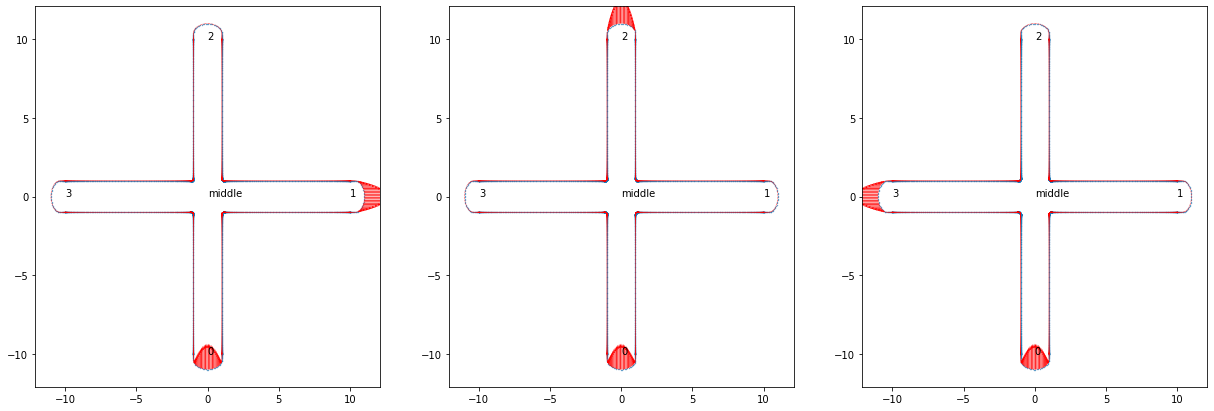

In [8]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
for i in range(3):
    axes[i].scatter(cross.x,cross.y,s=0.1)
    axes[i].quiver(cross.x,cross.y,flows_boundary_conditions[i][:,0],flows_boundary_conditions[i][:,1],scale=10,color='r')
    for k,j in enumerate(cross.caps):
        axes[i].text(cross.curves[j].p[0],cross.curves[j].p[1],str(k))
    axes[i].text(0,0,'middle')
    

In [9]:
solver = stokes2d(cross,gmres_tol=1e-12)

In [10]:
with cProfile.Profile() as pr:
    omegas = [solver.compute_omega(flows_boundary_condition,if_fmm=True) for flows_boundary_condition in flows_boundary_conditions]

running gmres
gmres did not converge 100
running gmres
gmres did not converge 100
running gmres
gmres did not converge 100


In [12]:
pstats.Stats(pr).strip_dirs().sort_stats('cumtime').print_stats()

         892574 function calls in 692.725 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  692.725  692.725 3657463987.py:2(<listcomp>)
        3    0.001    0.000  692.725  230.908 solver.py:57(compute_omega)
        3    0.000    0.000  692.724  230.908 <decorator-gen-5>:1(gmres)
        3    0.000    0.000  692.724  230.908 _threadsafety.py:42(caller)
        3    0.517    0.172  692.724  230.908 iterative.py:431(gmres)
    12601    0.050    0.000  692.200    0.055 _interface.py:201(matvec)
     6299    0.062    0.000  692.123    0.110 _interface.py:529(_matvec)
     6299    0.417    0.000  692.061    0.110 solver.py:105(A_fmm)
    31495  687.524    0.022  688.051    0.022 fmm2d.py:720(cfmm2d)
     6299    1.117    0.000  416.701    0.066 solver.py:151(K2_fmm)
     6299    0.806    0.000  274.810    0.044 solver.py:127(K1_fmm)
    12599    0.025    0.000    1.055    0.000 geometry.py:88(get_

In [11]:
with cProfile.Profile() as pr2:
    omegas_exact = [solver.compute_omega(flows_boundary_condition,if_fmm=False) for flows_boundary_condition in flows_boundary_conditions]

building the Nystorm matrix
running gmres
gmres converged
running gmres
gmres converged
running gmres
gmres converged


In [13]:
pstats.Stats(pr2).strip_dirs().sort_stats('cumtime').print_stats()

         8415 function calls in 3.666 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.666    3.666 2639309342.py:2(<listcomp>)
        3    0.005    0.002    3.666    1.222 solver.py:57(compute_omega)
        3    0.000    0.000    3.033    1.011 <decorator-gen-5>:1(gmres)
        3    0.000    0.000    3.033    1.011 _threadsafety.py:42(caller)
        3    0.053    0.018    3.033    1.011 iterative.py:431(gmres)
      839    0.006    0.000    2.979    0.004 _interface.py:201(matvec)
      418    0.001    0.000    2.969    0.007 _interface.py:189(_matvec)
      418    0.004    0.000    2.968    0.007 _interface.py:303(matmat)
      418    0.002    0.000    2.962    0.007 _interface.py:730(_matmat)
      445    2.961    0.007    2.961    0.007 {method 'dot' of 'numpy.ndarray' objects}
        1    0.616    0.616    0.626    0.626 solver.py:20(build_A)
        2    0.000    0.000    0.009  

In [18]:
[np.mean(np.abs(omegas[i] - omegas_exact[i])) for i in range(3)]

[8.104788835282559e-12, 2.8137095162406536e-12, 8.349628160354903e-12]

In [26]:
pressure_drops = []
    
for i,flow in enumerate(flows):
    # computing the pressure drop with unit flux of the flow i. 
    omega = omegas[i]
    pressure_drop = []

    start_point = cross.curves[inflow].p
    start_point_z = start_point[0] + 1j*start_point[1]
    start_point_pressure = solver.compute_pressure(start_point_z,omega)
    
    for j,flow2 in enumerate(flows):
        # integrating the pressure drop in the flow j. 
        end_point = cross.curves[flow2[1]].p
        end_point_z = end_point[0] + 1j*end_point[1]
        pressure_drop.append(solver.compute_pressure(end_point_z,omega)-start_point_pressure)
        
    pressure_drops.append(pressure_drop)

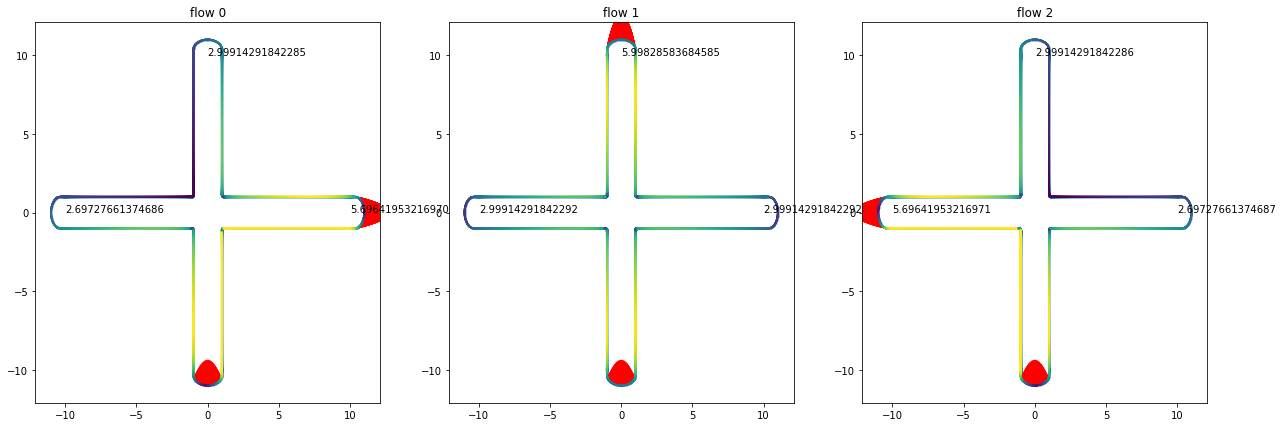

In [30]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
for i in range(3):
    axes[i].scatter(cross.x,cross.y,s=0.1)
    axes[i].quiver(cross.x,cross.y,flows_boundary_conditions[i][:,0],flows_boundary_conditions[i][:,1],scale=10,color='r')
    axes[i].title.set_text('flow '+str(i))
    
    for j in range(3):
        out = flows[j][1]
        end_point = cross.curves[out].p
        axes[i].text(end_point[0],end_point[1], f'{pressure_drops[i][j]:.14f}')
        
    axes[i].scatter(cross.x,cross.y,s=1,c=np.abs(omegas[i]),vmin=0,vmax=10)


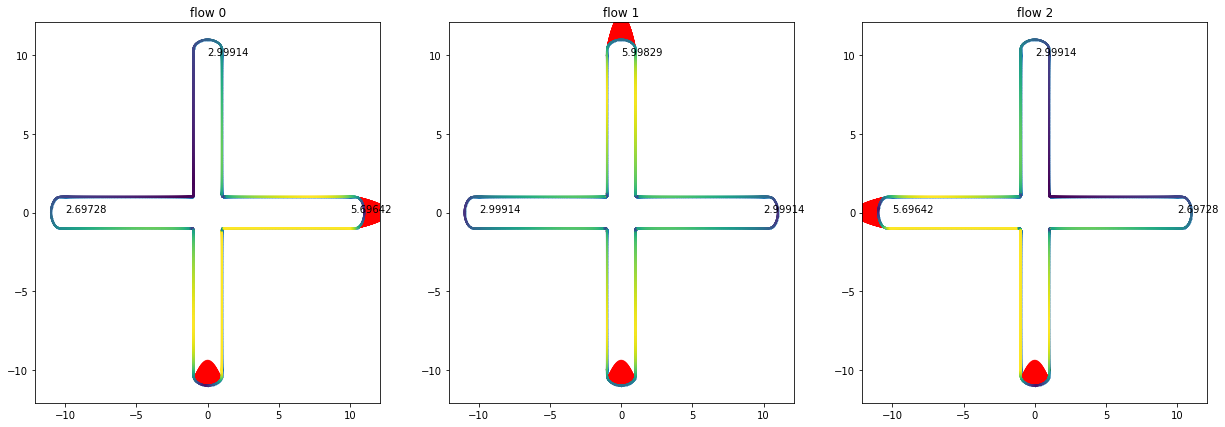

In [31]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
for i in range(3):
    axes[i].scatter(cross.x,cross.y,s=0.1)
    axes[i].quiver(cross.x,cross.y,flows_boundary_conditions[i][:,0],flows_boundary_conditions[i][:,1],scale=10,color='r')
    axes[i].title.set_text('flow '+str(i))
    
    for j in range(3):
        out = flows[j][1]
        end_point = cross.curves[out].p
        axes[i].text(end_point[0],end_point[1], f'{pressure_drops[i][j]:.5f}')
        
    axes[i].scatter(cross.x,cross.y,s=1,c=np.abs(omegas[i]),vmin=0,vmax=10)


this is pretty good. 